In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.8.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [2]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [3]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :Lx, :Ly, :Mag, :Energy]
)

cleandata (generic function with 1 method)

In [4]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [5]:
jobname = "small-sys"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,T,Lx,Ly,Mag,Energy
,Int64,Int64,Int64,Measurem…,Measurem…
1,1,20,20,0.0497±0.0013,-29.12±0.074
2,2,20,20,0.1874±0.0048,-28.707±0.086
3,3,20,20,0.8679±0.0054,-28.867±0.095
4,4,20,20,0.7912±0.0039,-25.35±0.1
5,5,20,20,0.06938±0.00043,-4.105±0.013
6,6,20,20,0.06242±0.00021,-3.2558±0.0066
7,7,20,20,0.05938±0.00021,-2.8033±0.0036
8,8,20,20,0.05776±0.00019,-2.4914±0.0035
9,9,20,20,0.05629±0.00019,-2.2483±0.0026


In [6]:
function generate_mctime_plot(task_no::Int, fig=Figure(size=(800, 400)), fig_pos=(1, 1))
    ax_P = fig[fig_pos...] = Axis(
        fig,
        title="Magnetization vs. Bin #",
        xlabel="Bin #",
        ylabel="P",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        mag_samples = read(observables, "Mag/samples")
        n = length(mag_samples)
        init = 1
        lines!(
            ax_P,
            collect(1:n),
            mag_samples[1:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

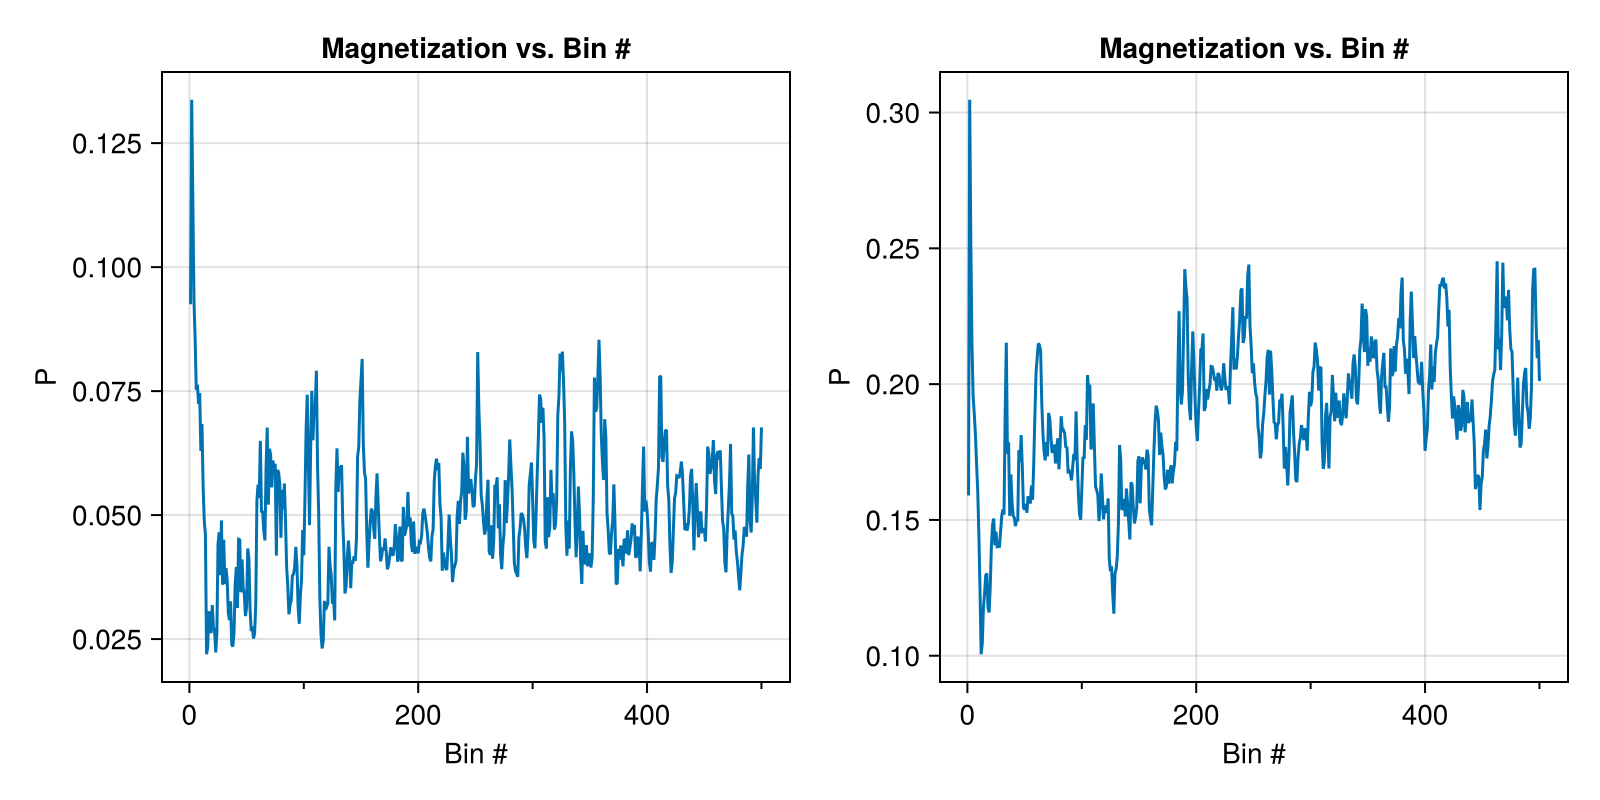

In [7]:
fig = Figure(size=(400, 800))
fig = generate_mctime_plot(1)
generate_mctime_plot(2, fig, (1, 2))

In [8]:
function generate_spins(task_no::Int)
    fig = Figure(size=(600, 600))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)

        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
    end

    return fig
end

generate_spins (generic function with 1 method)

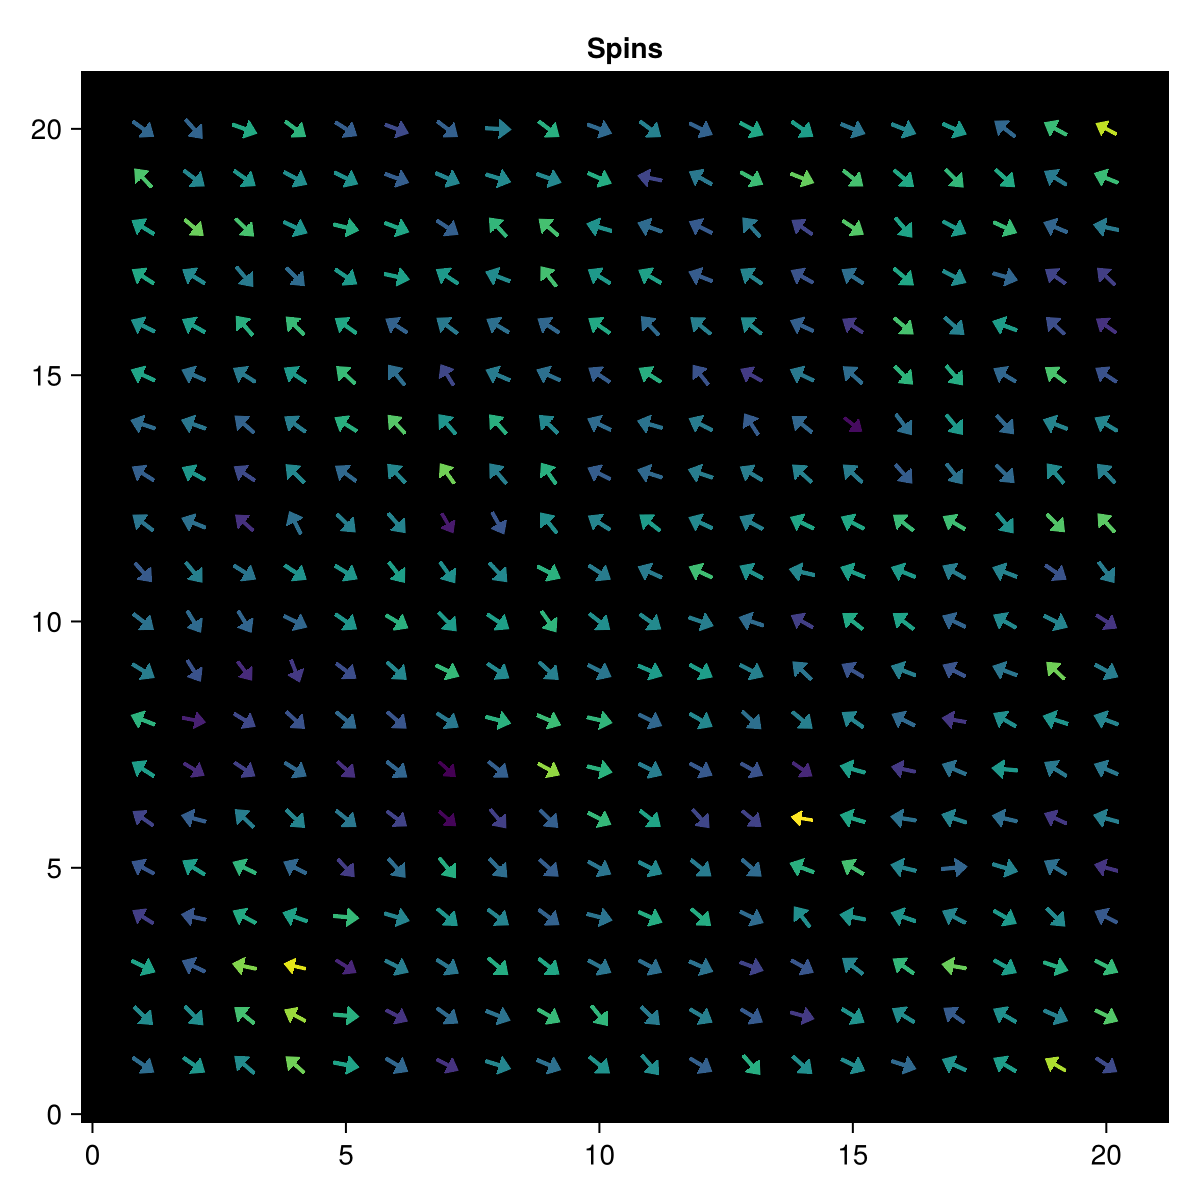

In [11]:
generate_spins(1)

In [10]:
i = 1
println(data[i, :])
task_str = lpad(i, 4, "0")

fig = Figure(size=(600, 600))
h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
    spins = PeriodicArray(map(
        t -> [t[:data][1], t[:data][2], t[:data][3]],
        read(file, "simulation/spins")
    ))

    Lx, Ly = size(spins)
    spinxs = getindex.(spins, 1)
    spinys = getindex.(spins, 2)
    spinzs = getindex.(spins, 3)
    strength = spinzs

    fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
    arrows2d!(1:Lx, 1:Ly, spinxs, spinys, lengthscale=0.7, align=:center,
              color=spinzs, colorrange=(-1, 1))
end

fig

DataFrameRow
 Row │ T      Lx     Ly     Mag            Energy       
     │ Int64  Int64  Int64  Measurem…      Measurem…    
─────┼──────────────────────────────────────────────────
   1 │     1     20     20  0.0497±0.0013  -29.12±0.074
